# SEIR Simulations for COVID-19 Spread

## 100 Node Simulation

### SEIR without Isolation

In [ ]:
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Author: Mengchen Gong

In [ ]:
class SEIR_simulator_no_isolation:
    def __init__(self, G, n, days):
        self.n = n
        self.days = days
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.nodes = [0]*n
        # dicts for SEIR 
        # key: day
        # value: list of nodes
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
        self.spreadList = []
        self.gotList = []
        

    def SEIR_simulator(self):
        # begin with 1 infected node
        startNode = np.random.randint(0, self.n)
        self.nodes[startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(startNode)
        self.IList[0].append(startNode)
        self.spreadList.append(startNode)
        self.gotList.append(startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S ->(0.6) E ->(0.125) I
            if day > 6:            # only confirmed Infected need to consider recover
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)
                    
#         print(day)       
#         print("S:",self.SList[day])
#         print("E:",self.EList[day])
#         print("I:",self.IList[day])
#         print("R:",self.RList[day])
#         print("-------------------------------------------------------------")

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
            
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                self.spreadList.remove(node) # no longer able to spread
        
        

In [ ]:
n = 100
days = 45
G = nx.gnp_random_graph(n, 0.08)
SEIR_noIsolation = SEIR_simulator_no_isolation(G, n, days)
s_list, e_list, i_list, r_list = SEIR_noIsolation.SEIR_simulator()

In [ ]:
s = [len(s_list[i]) for i in range(days+1)]
e = [len(e_list[i]) for i in range(days+1)]
i = [len(i_list[i]) for i in range(days+1)]
r = [len(r_list[i]) for i in range(days+1)]

In [ ]:
print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

At timestep 12 have highest infected num: 58


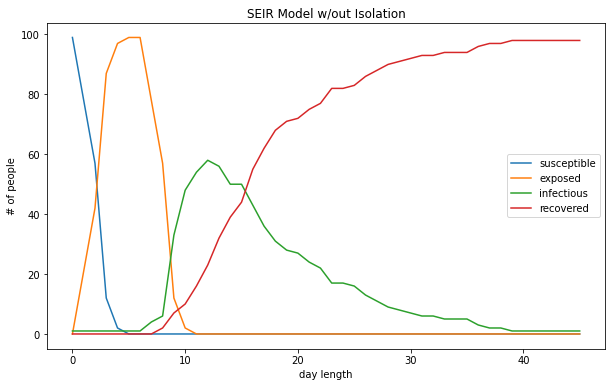

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s, label="susceptible")
plt.plot(np.arange(days+1), e, label="exposed")
plt.plot(np.arange(days+1), i, label="infectious")
plt.plot(np.arange(days+1), r, label="recovered")

ax.set_title("SEIR Model w/out Isolation")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

### SEIR Isolation at I

In [ ]:
class SEIR_simulator_I_isolation:
    def __init__(self, G, n, days, edgeList):
        self.n = n
        self.days = days
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.nodes = [0]*n
        # dicts for SEIR 
        # key: day
        # value: list of nodes
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
        self.spreadList = []
        self.gotList = []
        

    def SEIR_simulator(self):
        # begin with 1 infected node
        startNode = np.random.randint(0, self.n)
        self.nodes[startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(startNode)
        self.IList[0].append(startNode)
        self.spreadList.append(startNode)
        self.gotList.append(startNode)
        self.G_grid.add_node(startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6:            
                self.isolate_I(day)# Isolation
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)
                    
#         print(day)       
#         print("S:",self.SList[day])
#         print("E:",self.EList[day])
#         print("I:",self.IList[day])
#         print("R:",self.RList[day])
#         print("-------------------------------------------------------------")

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
            # print("During duration", days, "days, have total", len(list(set(self.gotList))), "people affected")
    
    def isolate_I(self, day):
#         self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
            # print(self.G_grid.nodes())
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                self.G_grid.remove_node(node)# remove from grid isolation
#                 if node in self.spreadList:
#                     self.spreadList.remove(node) # no longer able to spread
        
        

In [ ]:
n = 100
days = 45
# G_I_isolate = nx.gnp_random_graph(n, 0.08)
edgeDict = {}
# for node in range(n):
#     edgeDict[node] = list(G_I_isolate.edges(node))
for node in range(n):
    edgeDict[node] = list(G.edges(node))
    
SEIR_I_Isolation = SEIR_simulator_I_isolation(G, n, days, edgeDict)
s_list_i, e_list_i, i_list_i, r_list_i = SEIR_I_Isolation.SEIR_simulator()

In [ ]:
s_i = [len(s_list_i[i]) for i in range(days+1)]
e_i = [len(e_list_i[i]) for i in range(days+1)]
i_i = [len(i_list_i[i]) for i in range(days+1)]
r_i = [len(r_list_i[i]) for i in range(days+1)]

In [ ]:
print("At timestep",i_i.index(max(i_i)), "have highest infected num:" , max(i_i))

At timestep 17 have highest infected num: 50


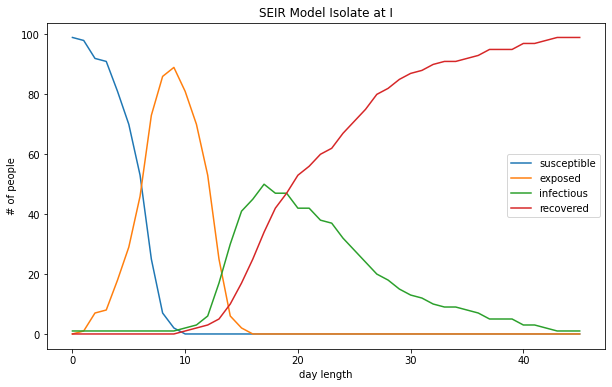

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s_i, label="susceptible")
plt.plot(np.arange(days+1), e_i, label="exposed")
plt.plot(np.arange(days+1), i_i, label="infectious")
plt.plot(np.arange(days+1), r_i, label="recovered")

ax.set_title("SEIR Model Isolate at I")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

### SEIR Isolation at EI

In [ ]:
class SEIR_simulator_EI_isolation:
    def __init__(self, G, n, days, edgeList, idays, p_se_isolation, delay):
        self.n = n
        self.days = days
        self.p_se_isolation = p_se_isolation
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.idays = idays
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.delay = delay
        self.nodes = [0]*n
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        self.isolate = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
            self.isolate[timestep] = []
        self.spreadList = []
        self.gotList = []
        self.startNode = np.random.randint(0, self.n)
        

    def SEIR_simulator(self):
        
        self.nodes[self.startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(self.startNode)
        self.IList[0].append(self.startNode)
        self.spreadList.append(self.startNode)
        self.gotList.append(self.startNode)
        self.G_grid.add_node(self.startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6: 
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))
        self.isolate[day] = list(set(self.isolate[day] + self.isolate[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
                            
        # 2 days delay, then start isolate 50% esposed from day before
        if day > self.delay:
            self.isolate_EI(day) #Isolate
    
    def isolate_EI(self, day):
        
#         print('Day',day,'In Isolation:')
#         print("Isolation list:", self.isolate[day])
#         print("nodes in list:", self.G_grid.nodes())
        
        # remove the ones after isolation
        if day > self.idays:
            for node in self.isolate[day-self.idays]:
                # not infected after isolation, put back in G
                if node in self.G_grid.nodes() and node not in self.gotList:
                    self.G_grid.remove_node(node)
                    if node in self.isolate[day]:
                        self.isolate[day].remove(node)
                    self.SList[day].append(node)
                    self.G.add_node(node)
                    # put back into original network
                    for adj in self.edgeList[node]:
                        if adj in self.G.nodes():
                            self.G.add_edge(adj, node)
            self.isolate_I(day) # Isolate all infected
        
        # add in new isolated nodes, 50% chance
        for i_node in list(set(self.EList[day-self.delay])):
            if np.random.uniform(0,1) <= 0.5:
                if i_node in self.spreadList:
                    self.spreadList.remove(i_node)
                self.isolate[day].append(i_node)
                if i_node in self.G.nodes():
                    self.G.remove_node(i_node)
                self.isolate[day].append(i_node)
                n_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
                self.G_grid.add_node(i_node)
                for n in n_nodes:
                    if len(list(self.G_grid.edges(n))) < 4:
                        self.G_grid.add_edge(i_node, n)

        # Grid isolation
        for node in self.G_grid.nodes():
            if node in self.gotList:
                for adj in self.G_grid.adj[node]:
                    # during Isolation got Exposed
                    if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se_isolation: 
                        # 0.125 prob E to I
                        if np.random.uniform(0,1) <= self.p_ei:
                            self.nodes[adj] = 1           # Will not get infected again 
                            self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                            self.gotList.append(adj)      # Track all the nodes has been infected in the history
                            self.EIList[day].remove(adj)  # Nodes won't be exposed again
                            
    def isolate_I(self, day):
        # all infected nodes will be added in isolation
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                if node in self.G_grid.nodes():
                    self.G_grid.remove_node(node)# remove from grid isolation
        
        

In [ ]:
n = 100
days = 45
G = nx.gnp_random_graph(n, 0.08)
edgeDict = {}
for node in range(n):
    edgeDict[node] = list(G.edges(node))
    
SEIR_EI_Isolation = SEIR_simulator_EI_isolation(G, n, days, edgeDict, 6, 0.6, 2)
s_list_ei, e_list_ei, i_list_ei, r_list_ei = SEIR_EI_Isolation.SEIR_simulator()

In [ ]:
s_ei = [len(s_list_ei[i]) for i in range(days+1)]
e_ei = [len(e_list_ei[i]) for i in range(days+1)]
i_ei = [len(i_list_ei[i]) for i in range(days+1)]
r_ei = [len(r_list_ei[i]) for i in range(days+1)]

In [ ]:
print("At timestep",i_ei.index(max(i_ei)), "have highest infected num:" , max(i_ei))

At timestep 16 have highest infected num: 43


#### Isolate 6 days

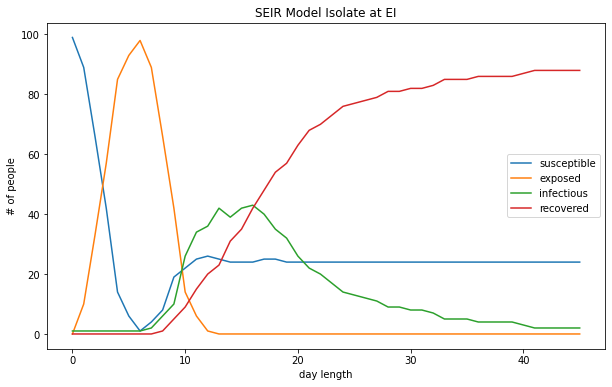

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s_ei, label="susceptible")
plt.plot(np.arange(days+1), e_ei, label="exposed")
plt.plot(np.arange(days+1), i_ei, label="infectious")
plt.plot(np.arange(days+1), r_ei, label="recovered")

ax.set_title("SEIR Model Isolate at EI")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Isolate 14 days

In [ ]:
n = 100
days = 45
G = nx.gnp_random_graph(n, 0.08)
edgeDict = {}
for node in range(n):
    edgeDict[node] = list(G.edges(node))
    
SEIR_EI_Isolation = SEIR_simulator_EI_isolation(G, n, days, edgeDict, 14, 0.6, 2)
s_list_ei, e_list_ei, i_list_ei, r_list_ei = SEIR_EI_Isolation.SEIR_simulator()

s_ei = [len(s_list_ei[i]) for i in range(days+1)]
e_ei = [len(e_list_ei[i]) for i in range(days+1)]
i_ei = [len(i_list_ei[i]) for i in range(days+1)]
r_ei = [len(r_list_ei[i]) for i in range(days+1)]

print("At timestep",i_ei.index(max(i_ei)), "have highest infected num:" , max(i_ei))

At timestep 13 have highest infected num: 37


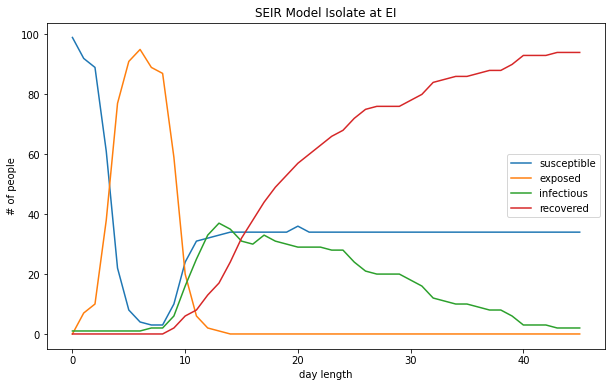

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s_ei, label="susceptible")
plt.plot(np.arange(days+1), e_ei, label="exposed")
plt.plot(np.arange(days+1), i_ei, label="infectious")
plt.plot(np.arange(days+1), r_ei, label="recovered")

ax.set_title("SEIR Model Isolate at EI")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

## Run on real network *Caltech36.txt*
### No Isolation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/My Drive/'    # add shortcut to drive, change root_dir to your drive 
base_dir = root_dir + 'Network Project/Code/'
path = base_dir + 'Caltech36.txt'
attr_file = base_dir + 'Caltech36_attr.txt'

In [ ]:
class SEIR_simulator_no_isolation_caltech:
    def __init__(self, G, n, days):
        self.n = n
        self.days = days
        self.p_se = 0.2   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.nodes = [0]*n
        # dicts for SEIR 
        # key: day
        # value: list of nodes
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
        self.spreadList = []
        self.gotList = []
        

    def SEIR_simulator(self):
        # begin with 1 infected node
        startNode = np.random.randint(0, self.n)
        self.nodes[startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(startNode)
        self.IList[0].append(startNode)
        self.spreadList.append(startNode)
        self.gotList.append(startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S ->(0.6) E ->(0.125) I
            if day > 6:            # only confirmed Infected need to consider recover
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
                            
            
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                self.spreadList.remove(node) # no longer able to spread
        
        

In [ ]:
G_caltech1 = nx.read_edgelist(path, nodetype=int)
n_caltech = G_caltech1.number_of_nodes()
days = 45
print(n_caltech)

769


### No Isolate

#### Original Probability

At timestep 7 have highest infected num: 522


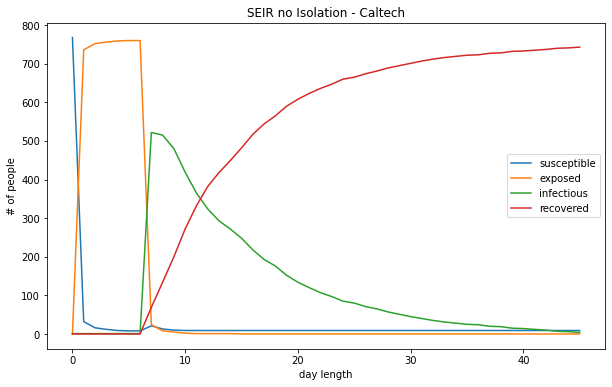

In [ ]:
G_caltech1 = nx.read_edgelist(path, nodetype=int)
SEIR_caltech = SEIR_simulator_no_isolation(G_caltech1, n_caltech+1, days)
s_list1, e_list1, i_list1, r_list1 = SEIR_caltech.SEIR_simulator()

s1 = [len(s_list1[i]) for i in range(days+1)]
e1 = [len(e_list1[i]) for i in range(days+1)]
i1 = [len(i_list1[i]) for i in range(days+1)]
r1 = [len(r_list1[i]) for i in range(days+1)]
print("At timestep",i1.index(max(i1)), "have highest infected num:" , max(i1))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s1, label="susceptible")
plt.plot(np.arange(days+1), e1, label="exposed")
plt.plot(np.arange(days+1), i1, label="infectious")
plt.plot(np.arange(days+1), r1, label="recovered")

ax.set_title("SEIR no Isolation - Caltech")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Modified Probability

At timestep 12 have highest infected num: 405


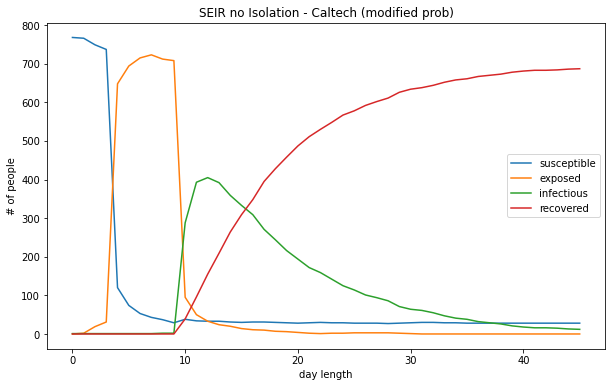

In [ ]:
G_caltech1 = nx.read_edgelist(path, nodetype=int)
SEIR_caltech = SEIR_simulator_no_isolation_caltech(G_caltech1, n_caltech+1, days)
s_list1, e_list1, i_list1, r_list1 = SEIR_caltech.SEIR_simulator()

s1 = [len(s_list1[i]) for i in range(days+1)]
e1 = [len(e_list1[i]) for i in range(days+1)]
i1 = [len(i_list1[i]) for i in range(days+1)]
r1 = [len(r_list1[i]) for i in range(days+1)]
print("At timestep",i1.index(max(i1)), "have highest infected num:" , max(i1))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s1, label="susceptible")
plt.plot(np.arange(days+1), e1, label="exposed")
plt.plot(np.arange(days+1), i1, label="infectious")
plt.plot(np.arange(days+1), r1, label="recovered")

ax.set_title("SEIR no Isolation - Caltech (modified prob)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

### Isolate at I

In [ ]:
class SEIR_simulator_I_isolation_caltech:
    def __init__(self, G, n, days, edgeList):
        self.n = n
        self.days = days
        self.p_se = 0.2   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.nodes = [0]*n
        # dicts for SEIR 
        # key: day
        # value: list of nodes
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
        self.spreadList = []
        self.gotList = []
        

    def SEIR_simulator(self):
        # begin with 1 infected node
        startNode = np.random.randint(0, self.n)
        self.nodes[startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(startNode)
        self.IList[0].append(startNode)
        self.spreadList.append(startNode)
        self.gotList.append(startNode)
        self.G_grid.add_node(startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6:            
                self.isolate_I(day)# Isolation
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)
                    
#         print(day)       
#         print("S:",self.SList[day])
#         print("E:",self.EList[day])
#         print("I:",self.IList[day])
#         print("R:",self.RList[day])
#         print("-------------------------------------------------------------")

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
#             print("During duration", days, "days, have total", len(list(set(self.gotList))), "people affected")
    
    def isolate_I(self, day):
#         self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
#             print(self.G_grid.nodes())
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                self.G_grid.remove_node(node)# remove from grid isolation
#                 if node in self.spreadList:
#                     self.spreadList.remove(node) # no longer able to spread
        
        

#### Original Probability

At timestep 8 have highest infected num: 531


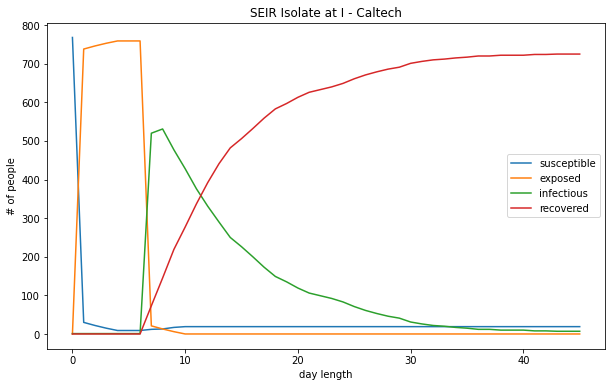

In [ ]:
G_caltech2 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
# print(G_caltech2.nodes())
for node in G_caltech2.nodes():
#     print(G_caltech2.edges(node))
    caltech_edges[node] = list(G_caltech2.edges(node))

SEIR_caltech_I = SEIR_simulator_I_isolation(G_caltech2, n_caltech+1, days, caltech_edges)
s_list2, e_list2, i_list2, r_list2 = SEIR_caltech_I.SEIR_simulator()

s2 = [len(s_list2[i]) for i in range(days+1)]
e2 = [len(e_list2[i]) for i in range(days+1)]
i2 = [len(i_list2[i]) for i in range(days+1)]
r2 = [len(r_list2[i]) for i in range(days+1)]
print("At timestep",i2.index(max(i2)), "have highest infected num:" , max(i2))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s2, label="susceptible")
plt.plot(np.arange(days+1), e2, label="exposed")
plt.plot(np.arange(days+1), i2, label="infectious")
plt.plot(np.arange(days+1), r2, label="recovered")

ax.set_title("SEIR Isolate at I - Caltech")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Modified Probability

At timestep 8 have highest infected num: 384


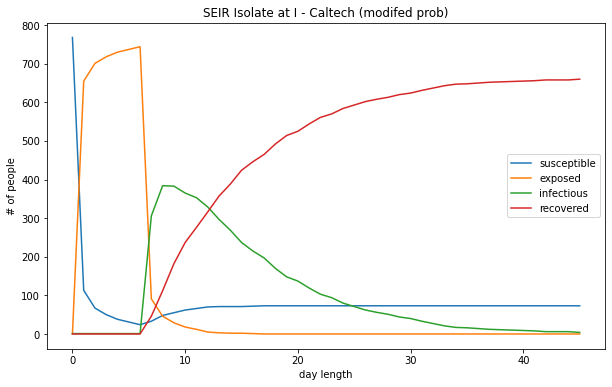

In [ ]:
G_caltech2 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
# print(G_caltech2.nodes())
for node in G_caltech2.nodes():
#     print(G_caltech2.edges(node))
    caltech_edges[node] = list(G_caltech2.edges(node))

SEIR_caltech_I = SEIR_simulator_I_isolation_caltech(G_caltech2, n_caltech+1, days, caltech_edges)
s_list2, e_list2, i_list2, r_list2 = SEIR_caltech_I.SEIR_simulator()

s2 = [len(s_list2[i]) for i in range(days+1)]
e2 = [len(e_list2[i]) for i in range(days+1)]
i2 = [len(i_list2[i]) for i in range(days+1)]
r2 = [len(r_list2[i]) for i in range(days+1)]
print("At timestep",i2.index(max(i2)), "have highest infected num:" , max(i2))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s2, label="susceptible")
plt.plot(np.arange(days+1), e2, label="exposed")
plt.plot(np.arange(days+1), i2, label="infectious")
plt.plot(np.arange(days+1), r2, label="recovered")

ax.set_title("SEIR Isolate at I - Caltech (modifed prob)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

### Isolate at EI

In [ ]:
class SEIR_simulator_EI_isolation_caltech:
    def __init__(self, G, n, days, edgeList, idays, p_se_isolation, delay):
        self.n = n
        self.days = days
        self.p_se_isolation = p_se_isolation
        self.p_se = 0.2   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.idays = idays
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.delay = delay
        self.nodes = [0]*n
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        self.isolate = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
            self.isolate[timestep] = []
        self.spreadList = []
        self.gotList = []
        self.startNode = np.random.randint(0, self.n)
        

    def SEIR_simulator(self):
        
        self.nodes[self.startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(self.startNode)
        self.IList[0].append(self.startNode)
        self.spreadList.append(self.startNode)
        self.gotList.append(self.startNode)
        self.G_grid.add_node(self.startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6: 
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))
        self.isolate[day] = list(set(self.isolate[day] + self.isolate[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
                            
        # 2 days delay, then start isolate 50% esposed from day before
        if day > self.delay:
            self.isolate_EI(day) #Isolate
    
    def isolate_EI(self, day):
        
#         print('Day',day,'In Isolation:')
#         print("Isolation list:", self.isolate[day])
#         print("nodes in list:", self.G_grid.nodes())
        
        # remove the ones after isolation
        if day > self.idays:
            for node in self.isolate[day-self.idays]:
                # not infected after isolation, put back in G
                if node in self.G_grid.nodes() and node not in self.gotList:
                    self.G_grid.remove_node(node)
                    if node in self.isolate[day]:
                        self.isolate[day].remove(node)
                    self.SList[day].append(node)
                    self.G.add_node(node)
                    # put back into original network
                    for adj in self.edgeList[node]:
                        if adj in self.G.nodes():
                            self.G.add_edge(adj, node)
            self.isolate_I(day) # Isolate all infected
        
        # add in new isolated nodes, 50% chance
        for i_node in list(set(self.EList[day-self.delay])):
            if np.random.uniform(0,1) <= 0.5:
                if i_node in self.spreadList:
                    self.spreadList.remove(i_node)
                self.isolate[day].append(i_node)
                if i_node in self.G.nodes():
                    self.G.remove_node(i_node)
                self.isolate[day].append(i_node)
                n_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
                self.G_grid.add_node(i_node)
                for n in n_nodes:
                    if len(list(self.G_grid.edges(n))) < 4:
                        self.G_grid.add_edge(i_node, n)

        # Grid isolation
        for node in self.G_grid.nodes():
            if node in self.gotList:
                for adj in self.G_grid.adj[node]:
                    # during Isolation got Exposed
                    if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se_isolation: 
                        # 0.125 prob E to I
                        if np.random.uniform(0,1) <= self.p_ei:
                            self.nodes[adj] = 1           # Will not get infected again 
                            self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                            self.gotList.append(adj)      # Track all the nodes has been infected in the history
                            self.EIList[day].remove(adj)  # Nodes won't be exposed again
                            
    def isolate_I(self, day):
        # all infected nodes will be added in isolation
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                if node in self.G_grid.nodes():
                    self.G_grid.remove_node(node)# remove from grid isolation
        
        

#### Isolate 6 days

##### Original Probability

At timestep 8 have highest infected num: 517


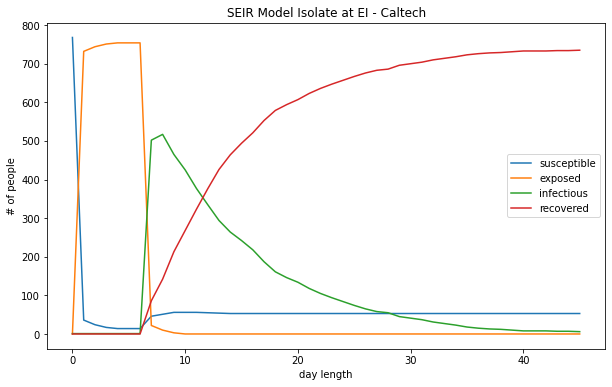

In [ ]:
G_caltech3 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
for node in G_caltech3.nodes():
    caltech_edges[node] = list(G_caltech3.edges(node))

SEIR_caltech_EI = SEIR_simulator_EI_isolation(G_caltech3, n_caltech+1, days, caltech_edges, 6, 0.6, 2)
s_list3, e_list3, i_list3, r_list3 = SEIR_caltech_EI.SEIR_simulator()

s3 = [len(s_list3[i]) for i in range(days+1)]
e3 = [len(e_list3[i]) for i in range(days+1)]
i3 = [len(i_list3[i]) for i in range(days+1)]
r3 = [len(r_list3[i]) for i in range(days+1)]
print("At timestep",i3.index(max(i3)), "have highest infected num:" , max(i3))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s3, label="susceptible")
plt.plot(np.arange(days+1), e3, label="exposed")
plt.plot(np.arange(days+1), i3, label="infectious")
plt.plot(np.arange(days+1), r3, label="recovered")

ax.set_title("SEIR Model Isolate at EI - Caltech")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Modifed Probability

At timestep 12 have highest infected num: 390


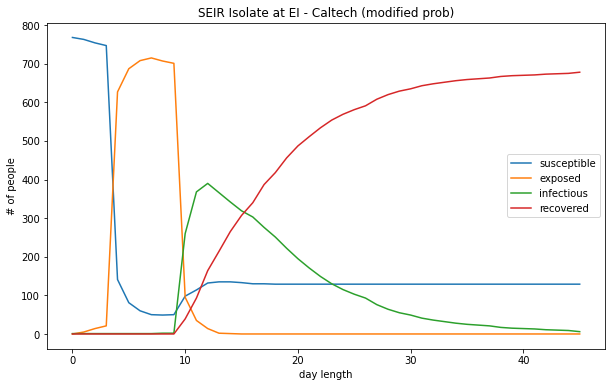

In [ ]:
G_caltech3 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
for node in G_caltech3.nodes():
    caltech_edges[node] = list(G_caltech3.edges(node))

SEIR_caltech_EI = SEIR_simulator_EI_isolation_caltech(G_caltech3, n_caltech+1, days, caltech_edges, 6, 0.6, 2)
s_list3, e_list3, i_list3, r_list3 = SEIR_caltech_EI.SEIR_simulator()

s3 = [len(s_list3[i]) for i in range(days+1)]
e3 = [len(e_list3[i]) for i in range(days+1)]
i3 = [len(i_list3[i]) for i in range(days+1)]
r3 = [len(r_list3[i]) for i in range(days+1)]
print("At timestep",i3.index(max(i3)), "have highest infected num:" , max(i3))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s3, label="susceptible")
plt.plot(np.arange(days+1), e3, label="exposed")
plt.plot(np.arange(days+1), i3, label="infectious")
plt.plot(np.arange(days+1), r3, label="recovered")

ax.set_title("SEIR Isolate at EI - Caltech (modified prob)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Isolate 14 days

##### Original Probability

At timestep 7 have highest infected num: 514


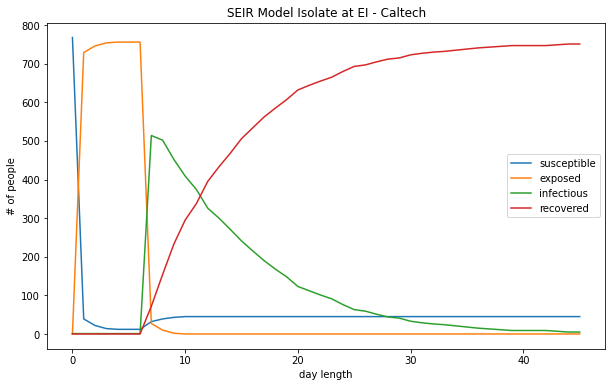

In [ ]:
G_caltech4 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
for node in G_caltech4.nodes():
    caltech_edges[node] = list(G_caltech4.edges(node))

SEIR_caltech_EI = SEIR_simulator_EI_isolation(G_caltech4, n_caltech+1, days, caltech_edges, 14, 0.6, 2)
s_list4, e_list4, i_list4, r_list4 = SEIR_caltech_EI.SEIR_simulator()

s4 = [len(s_list4[i]) for i in range(days+1)]
e4 = [len(e_list4[i]) for i in range(days+1)]
i4 = [len(i_list4[i]) for i in range(days+1)]
r4 = [len(r_list4[i]) for i in range(days+1)]
print("At timestep",i4.index(max(i4)), "have highest infected num:" , max(i4))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s4, label="susceptible")
plt.plot(np.arange(days+1), e4, label="exposed")
plt.plot(np.arange(days+1), i4, label="infectious")
plt.plot(np.arange(days+1), r4, label="recovered")

ax.set_title("SEIR Model Isolate at EI - Caltech")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Modified Probability

At timestep 10 have highest infected num: 395


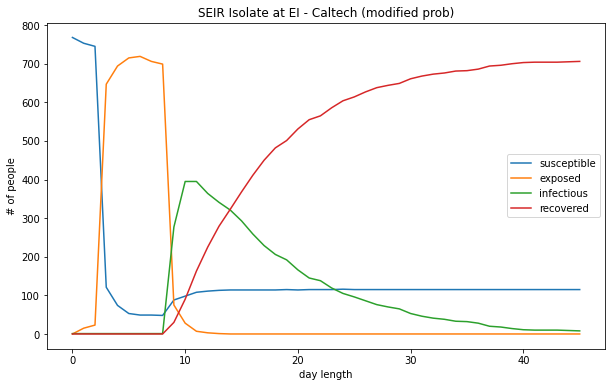

In [ ]:
G_caltech4 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
for node in G_caltech4.nodes():
    caltech_edges[node] = list(G_caltech4.edges(node))

SEIR_caltech_EI = SEIR_simulator_EI_isolation_caltech(G_caltech4, n_caltech+1, days, caltech_edges, 14, 0.6, 2)
s_list4, e_list4, i_list4, r_list4 = SEIR_caltech_EI.SEIR_simulator()

s4 = [len(s_list4[i]) for i in range(days+1)]
e4 = [len(e_list4[i]) for i in range(days+1)]
i4 = [len(i_list4[i]) for i in range(days+1)]
r4 = [len(r_list4[i]) for i in range(days+1)]
print("At timestep",i4.index(max(i4)), "have highest infected num:" , max(i4))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s4, label="susceptible")
plt.plot(np.arange(days+1), e4, label="exposed")
plt.plot(np.arange(days+1), i4, label="infectious")
plt.plot(np.arange(days+1), r4, label="recovered")

ax.set_title("SEIR Isolate at EI - Caltech (modified prob)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Isolate Immediately (no delay)

##### Original Probability

At timestep 7 have highest infected num: 527


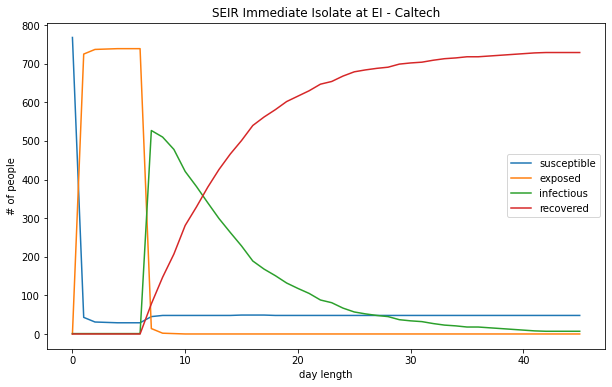

In [ ]:
G_caltech5 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
for node in G_caltech5.nodes():
    caltech_edges[node] = list(G_caltech5.edges(node))

SEIR_caltech_EI = SEIR_simulator_EI_isolation(G_caltech5, n_caltech+1, days, caltech_edges, 14, 0.6, 0)
s_list5, e_list5, i_list5, r_list5 = SEIR_caltech_EI.SEIR_simulator()

s5 = [len(s_list5[i]) for i in range(days+1)]
e5 = [len(e_list5[i]) for i in range(days+1)]
i5 = [len(i_list5[i]) for i in range(days+1)]
r5 = [len(r_list5[i]) for i in range(days+1)]
print("At timestep",i5.index(max(i5)), "have highest infected num:" , max(i5))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s5, label="susceptible")
plt.plot(np.arange(days+1), e5, label="exposed")
plt.plot(np.arange(days+1), i5, label="infectious")
plt.plot(np.arange(days+1), r5, label="recovered")

ax.set_title("SEIR Immediate Isolate at EI - Caltech")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Modified Probability

At timestep 13 have highest infected num: 304


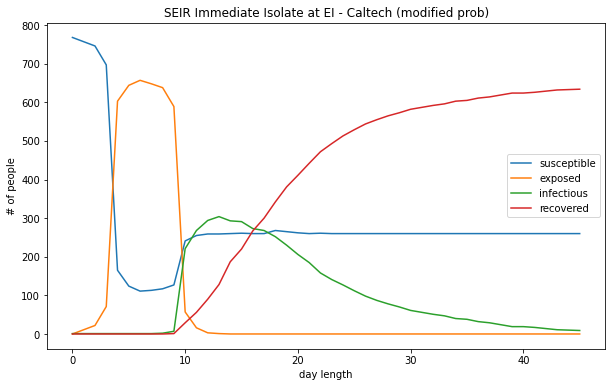

In [ ]:
G_caltech5 = nx.read_edgelist(path, nodetype=int)
caltech_edges = {}
for node in G_caltech5.nodes():
    caltech_edges[node] = list(G_caltech5.edges(node))

SEIR_caltech_EI = SEIR_simulator_EI_isolation_caltech(G_caltech5, n_caltech+1, days, caltech_edges, 14, 0.6, 0)
s_list5, e_list5, i_list5, r_list5 = SEIR_caltech_EI.SEIR_simulator()

s5 = [len(s_list5[i]) for i in range(days+1)]
e5 = [len(e_list5[i]) for i in range(days+1)]
i5 = [len(i_list5[i]) for i in range(days+1)]
r5 = [len(r_list5[i]) for i in range(days+1)]
print("At timestep",i5.index(max(i5)), "have highest infected num:" , max(i5))

fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s5, label="susceptible")
plt.plot(np.arange(days+1), e5, label="exposed")
plt.plot(np.arange(days+1), i5, label="infectious")
plt.plot(np.arange(days+1), r5, label="recovered")

ax.set_title("SEIR Immediate Isolate at EI - Caltech (modified prob)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

## Centrality Analysis

In [ ]:
class SEIR_simulator_no_isolation_centrality:
    def __init__(self, G, n, days, startNode):
        self.n = n
        self.days = days
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.nodes = [0]*n
        self.startNode = startNode
        # dicts for SEIR 
        # key: day
        # value: list of nodes
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
        self.spreadList = []
        self.gotList = []
        

    def SEIR_simulator(self):
        # begin with 1 infected node
        self.nodes[self.startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(self.startNode)
        self.IList[0].append(self.startNode)
        self.spreadList.append(self.startNode)
        self.gotList.append(self.startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S ->(0.6) E ->(0.125) I
            if day > 6:            # only confirmed Infected need to consider recover
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)
                    
        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
                            
            
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                self.spreadList.remove(node) # no longer able to spread
        
        

In [ ]:
class SEIR_simulator_I_isolation_centrality:
    def __init__(self, G, n, days, edgeList, startNode):
        self.n = n
        self.days = days
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.nodes = [0]*n
        self.startNode = startNode
        # dicts for SEIR 
        # key: day
        # value: list of nodes
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
        self.spreadList = []
        self.gotList = []
        

    def SEIR_simulator(self):
        # begin with 1 infected node
        self.nodes[self.startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(self.startNode)
        self.IList[0].append(self.startNode)
        self.spreadList.append(self.startNode)
        self.gotList.append(self.startNode)
        self.G_grid.add_node(self.startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6:            
                self.isolate_I(day)# Isolation
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
#             print("During duration", days, "days, have total", len(list(set(self.gotList))), "people affected")
    
    def isolate_I(self, day):
#         self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
#             print(self.G_grid.nodes())
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                self.G_grid.remove_node(node)# remove from grid isolation
#                 if node in self.spreadList:
#                     self.spreadList.remove(node) # no longer able to spread
        
        

In [ ]:
class SEIR_simulator_EI_isolation_centrality:
    def __init__(self, G, n, days, edgeList, startNode):
        self.n = n
        self.days = days
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.nodes = [0]*n
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        self.isolate = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
            self.isolate[timestep] = []
        self.spreadList = []
        self.gotList = []
        self.startNode = startNode
        

    def SEIR_simulator(self):
        
        self.nodes[self.startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(self.startNode)
        self.IList[0].append(self.startNode)
        self.spreadList.append(self.startNode)
        self.gotList.append(self.startNode)
        self.G_grid.add_node(self.startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6: 
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))
        self.isolate[day] = list(set(self.isolate[day] + self.isolate[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
                            
        # 2 days delay, then start isolate 50% esposed from day before
        if day > 2:
            self.isolate_EI(day) #Isolate
    
    def isolate_EI(self, day):
        
#         print('Day',day,'In Isolation:')
#         print("Isolation list:", self.isolate[day])
#         print("nodes in list:", self.G_grid.nodes())
        
        # remove the ones after isolation
        if day > 14:
            for node in self.isolate[day-14]:
                # not infected after isolation, put back in G
                if node in self.G_grid.nodes() and node not in self.gotList:
                    self.G_grid.remove_node(node)
                    if node in self.isolate[day]:
                        self.isolate[day].remove(node)
                    self.SList[day].append(node)
                    self.G.add_node(node)
                    # put back into original network
                    for adj in self.edgeList[node]:
                        if adj in self.G.nodes():
                            self.G.add_edge(adj, node)
            self.isolate_I(day) # Isolate all infected
        
        # add in new isolated nodes, 50% chance
        for i_node in list(set(self.EList[day-2])):
            if np.random.uniform(0,1) <= 0.5:
                if i_node in self.spreadList:
                    self.spreadList.remove(i_node)
                self.isolate[day].append(i_node)
                if i_node in self.G.nodes():
                    self.G.remove_node(i_node)
                self.isolate[day].append(i_node)
                n_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
                self.G_grid.add_node(i_node)
                for n in n_nodes:
                    if len(list(self.G_grid.edges(n))) < 4:
                        self.G_grid.add_edge(i_node, n)

        
        # Grid isolation
#         p_se_isolation = 0.1
        for node in self.G_grid.nodes():
            if node in self.gotList:
                for adj in self.G_grid.adj[node]:
                    # during Isolation got Exposed
                    if self.nodes[adj] == 0 and np.random.uniform(0,1) <= 0.05:#self.p_se: #p_se_isolation:
                        # 0.125 prob E to I
                        if np.random.uniform(0,1) <= 0.1:#self.p_ei:
                            self.nodes[adj] = 1           # Will not get infected again 
                            self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                            self.gotList.append(adj)      # Track all the nodes has been infected in the history
                            self.EIList[day].remove(adj)  # Nodes won't be exposed again
                            
    def isolate_I(self, day):
        # all infected nodes will be added in isolation
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                if node in self.G_grid.nodes():
                    self.G_grid.remove_node(node)# remove from grid isolation
        
        

### Degree, Harmonic, Eigen, Betweeness centrality

In [ ]:
high_degC = [709, 90, 223] 
low_degC = [713, 536, 533]
high_harC = [3, 709, 90, 223]
low_harC = [35, 147, 169, 437] 
high_eigC = [709, 90, 623] 
low_eigC =  [437, 169, 147, 35] 
high_betC = [3, 709, 223, 278]
low_betC = [751, 744, 743]

### No Isolation Centrality Analysis

#### Degree Centrality

##### High-Low Compare

At timestep 7 have highest infected num: 510
At timestep 0 have highest infected num: 1


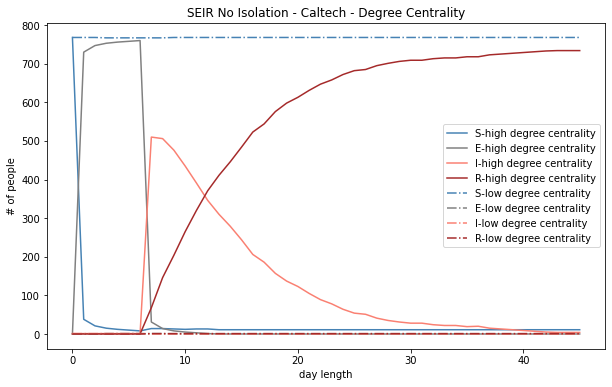

In [ ]:
deg = [709, 713]
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in deg:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    if deg.index(startNode) == 0:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-high degree centrality")
        plt.plot(np.arange(days+1), e, color="grey", label="E-high degree centrality")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-high degree centrality")
        plt.plot(np.arange(days+1), r, color="brown", label="R-high degree centrality")
    else:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), e, color="grey", label="E-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), r, color="brown",  label="R-low degree centrality", linestyle="-.")

ax.set_title("SEIR No Isolation - Caltech - Degree Centrality")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### High

At timestep 7 have highest infected num: 515
At timestep 7 have highest infected num: 524
At timestep 7 have highest infected num: 522


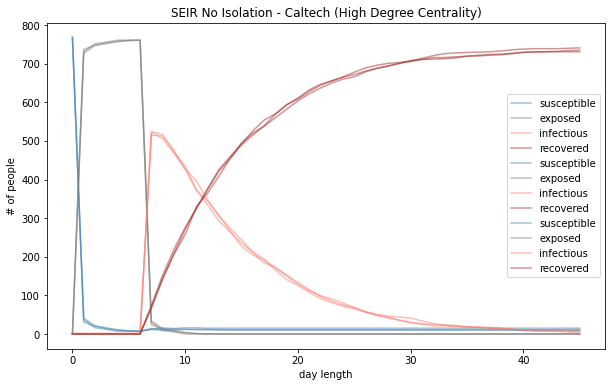

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_degC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))
    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (High Degree Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 0 have highest infected num: 1
At timestep 7 have highest infected num: 504
At timestep 0 have highest infected num: 1


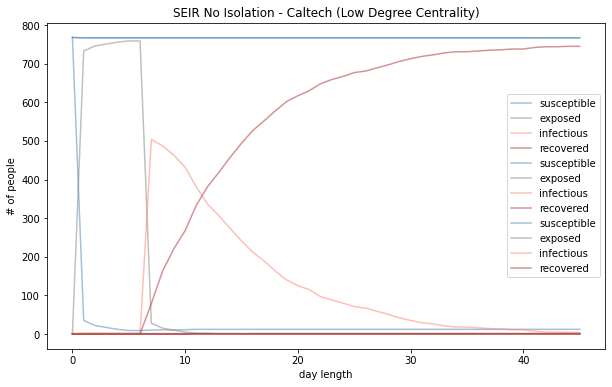

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_degC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (Low Degree Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Harmonic Centrality

##### High

At timestep 11 have highest infected num: 528
At timestep 7 have highest infected num: 519
At timestep 8 have highest infected num: 501
At timestep 8 have highest infected num: 520


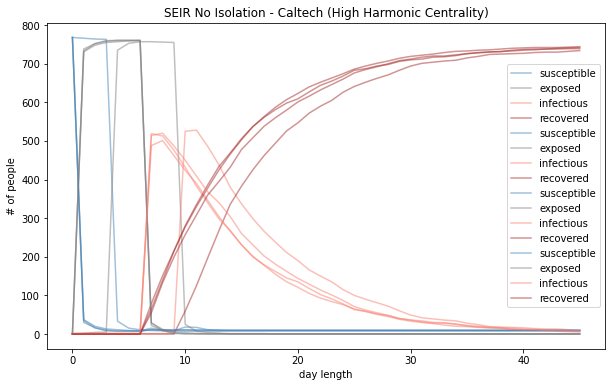

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_harC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (High Harmonic Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 8 have highest infected num: 2


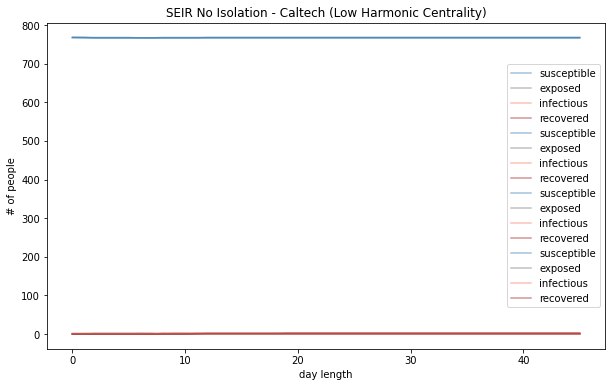

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_harC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (Low Harmonic Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Eigenvector Centrality

##### High

At timestep 8 have highest infected num: 519
At timestep 8 have highest infected num: 528
At timestep 8 have highest infected num: 520


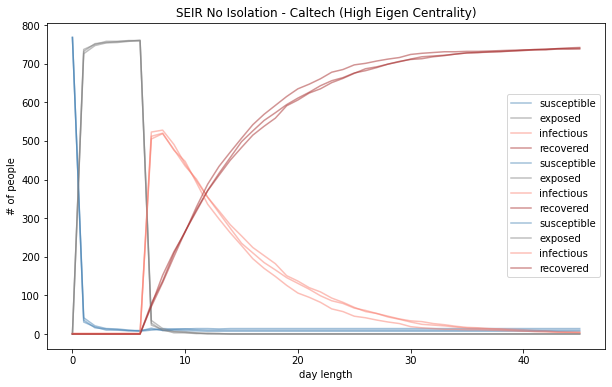

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_eigC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))
  
    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (High Eigen Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low 

At timestep 11 have highest infected num: 2
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 8 have highest infected num: 2


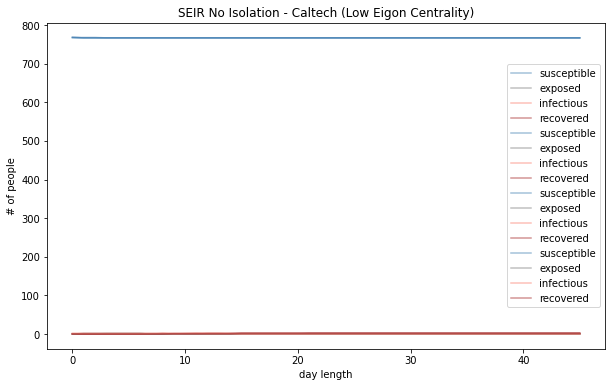

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_eigC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (Low Eigon Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Betweenness centrality

At timestep 12 have highest infected num: 513
At timestep 14 have highest infected num: 510


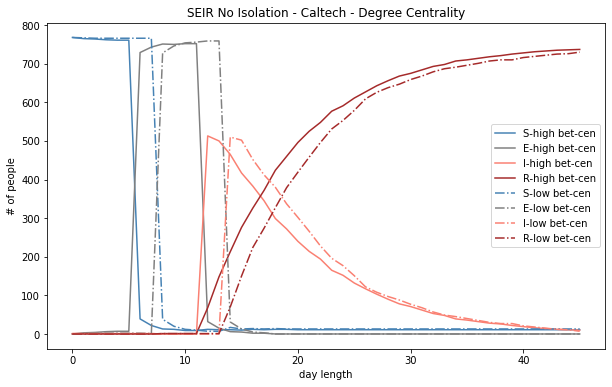

In [ ]:
bet = [3, 743]
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in bet:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    if bet.index(startNode) == 0:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-high bet-cen")
        plt.plot(np.arange(days+1), e, color="grey", label="E-high bet-cen")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-high bet-cen")
        plt.plot(np.arange(days+1), r, color="brown", label="R-high bet-cen")
    else:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-low bet-cen", linestyle="-.")
        plt.plot(np.arange(days+1), e, color="grey", label="E-low bet-cen", linestyle="-.")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-low bet-cen", linestyle="-.")
        plt.plot(np.arange(days+1), r, color="brown",  label="R-low bet-cen", linestyle="-.")

ax.set_title("SEIR No Isolation - Caltech - Degree Centrality")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### High

At timestep 9 have highest infected num: 513
At timestep 7 have highest infected num: 521
At timestep 7 have highest infected num: 513
At timestep 8 have highest infected num: 517


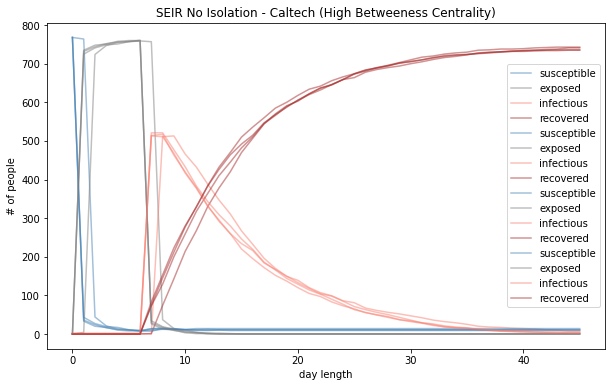

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_betC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (High Betweeness Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 11 have highest infected num: 509
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1


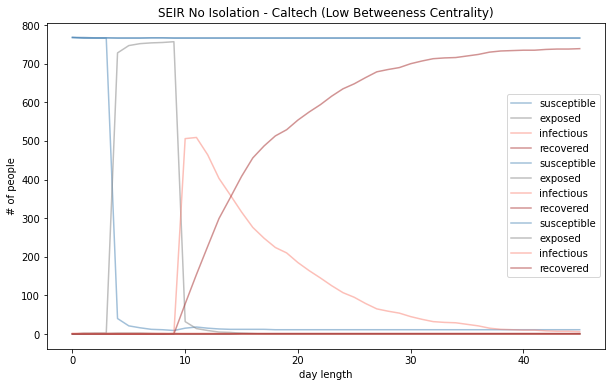

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_betC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    # print(G_caltech2.nodes())
    for node in G_caltech_c.nodes():
    #     print(G_caltech2.edges(node))
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_no = SEIR_simulator_no_isolation_centrality(G_caltech_c, n_caltech+1, days, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_no.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR No Isolation - Caltech (Low Betweeness Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

### I Isolation Centrality Analysis

#### Degree Centrality

##### High-Low Compare

At timestep 7 have highest infected num: 503
At timestep 9 have highest infected num: 494


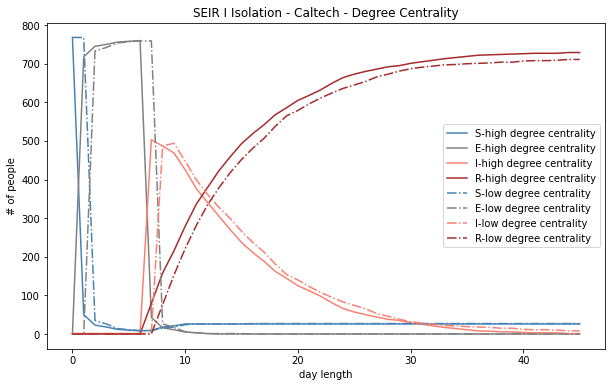

In [ ]:
deg = [709, 536]
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in deg:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    if deg.index(startNode) == 0:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-high degree centrality")
        plt.plot(np.arange(days+1), e, color="grey", label="E-high degree centrality")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-high degree centrality")
        plt.plot(np.arange(days+1), r, color="brown", label="R-high degree centrality")
    else:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), e, color="grey", label="E-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), r, color="brown",  label="R-low degree centrality", linestyle="-.")

ax.set_title("SEIR I Isolation - Caltech - Degree Centrality")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### High

At timestep 7 have highest infected num: 532
At timestep 8 have highest infected num: 519
At timestep 7 have highest infected num: 514


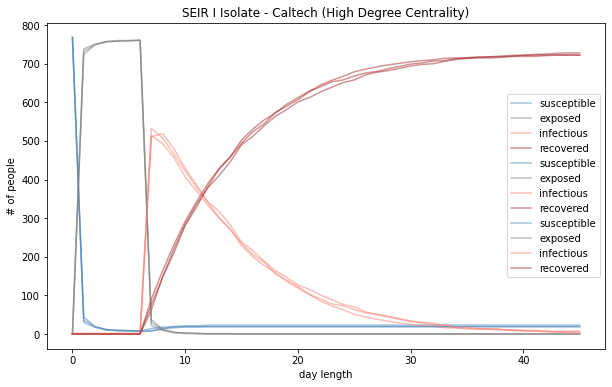

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_degC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (High Degree Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 12 have highest infected num: 499
At timestep 8 have highest infected num: 500
At timestep 0 have highest infected num: 1


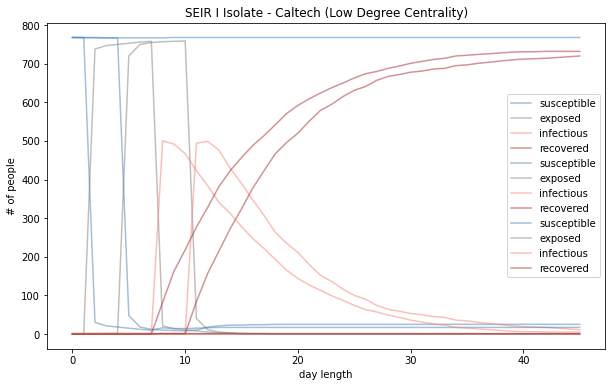

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_degC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (Low Degree Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Harmonic Centrality

##### High

At timestep 7 have highest infected num: 514
At timestep 7 have highest infected num: 522
At timestep 7 have highest infected num: 524
At timestep 7 have highest infected num: 517


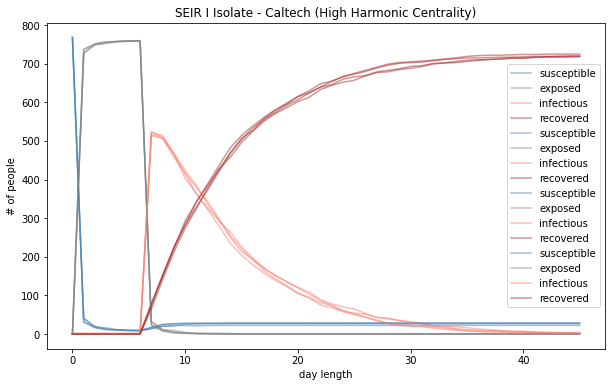

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_harC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (High Harmonic Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1


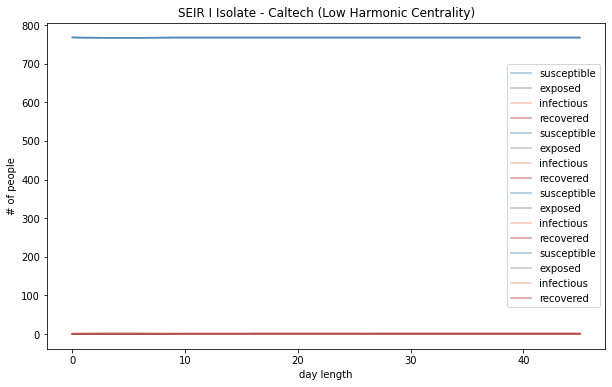

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_harC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (Low Harmonic Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Eigenvector Centrality

##### High

At timestep 8 have highest infected num: 511
At timestep 7 have highest infected num: 517
At timestep 7 have highest infected num: 495


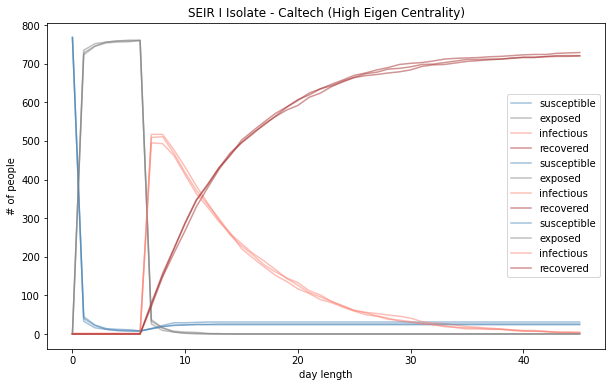

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_eigC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (High Eigen Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 9 have highest infected num: 2
At timestep 7 have highest infected num: 2
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1


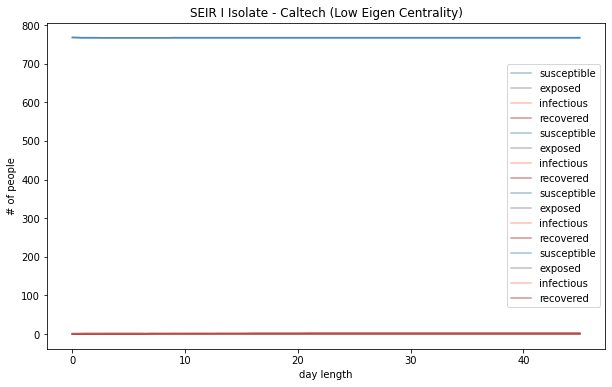

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_eigC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (Low Eigen Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Betweeness Centrality

##### High-Low Compare

At timestep 8 have highest infected num: 525
At timestep 0 have highest infected num: 1


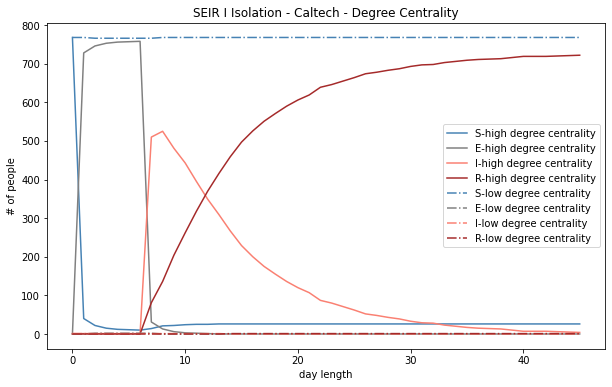

In [ ]:
bet = [3, 743]
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in bet:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    if bet.index(startNode) == 0:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-high degree centrality")
        plt.plot(np.arange(days+1), e, color="grey", label="E-high degree centrality")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-high degree centrality")
        plt.plot(np.arange(days+1), r, color="brown", label="R-high degree centrality")
    else:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), e, color="grey", label="E-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), r, color="brown",  label="R-low degree centrality", linestyle="-.")

ax.set_title("SEIR I Isolation - Caltech - Degree Centrality")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### High

At timestep 10 have highest infected num: 495
At timestep 8 have highest infected num: 520
At timestep 7 have highest infected num: 522
At timestep 8 have highest infected num: 510


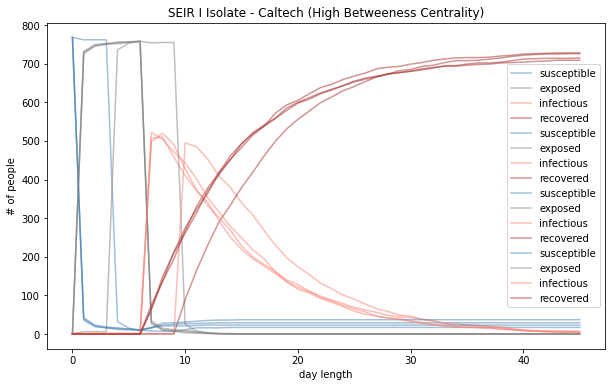

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_betC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (High Betweeness Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 11 have highest infected num: 521
At timestep 0 have highest infected num: 1
At timestep 7 have highest infected num: 515


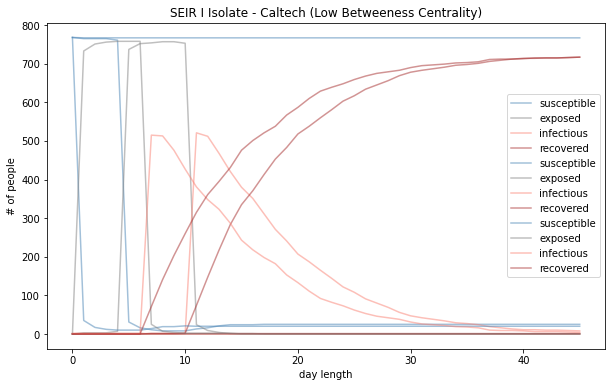

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_betC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_I_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR I Isolate - Caltech (Low Betweeness Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

### EI Isolation Centrality Analysis

#### Degree Centrality

##### High-Low Compare

At timestep 7 have highest infected num: 499
At timestep 0 have highest infected num: 1


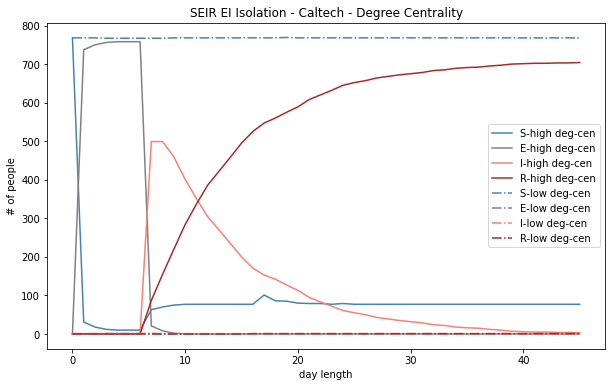

In [ ]:
deg = [709, 713]
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in deg:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_I = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_I.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    if deg.index(startNode) == 0:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-high deg-cen")
        plt.plot(np.arange(days+1), e, color="grey", label="E-high deg-cen")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-high deg-cen")
        plt.plot(np.arange(days+1), r, color="brown", label="R-high deg-cen")
    else:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-low deg-cen", linestyle="-.")
        plt.plot(np.arange(days+1), e, color="grey", label="E-low deg-cen", linestyle="-.")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-low deg-cen", linestyle="-.")
        plt.plot(np.arange(days+1), r, color="brown",  label="R-low deg-cen", linestyle="-.")

ax.set_title("SEIR EI Isolation - Caltech - Degree Centrality")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### High

At timestep 8 have highest infected num: 504
At timestep 8 have highest infected num: 515
At timestep 7 have highest infected num: 518


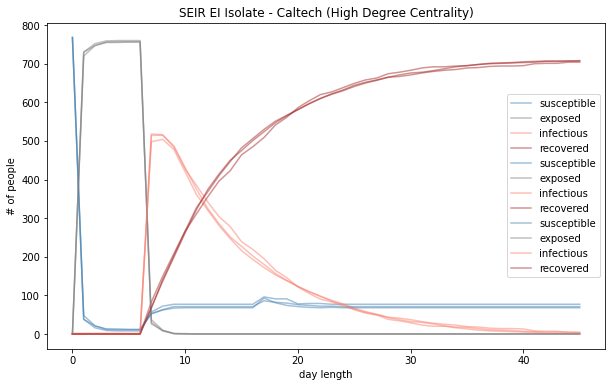

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_degC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (High Degree Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 9 have highest infected num: 518
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1


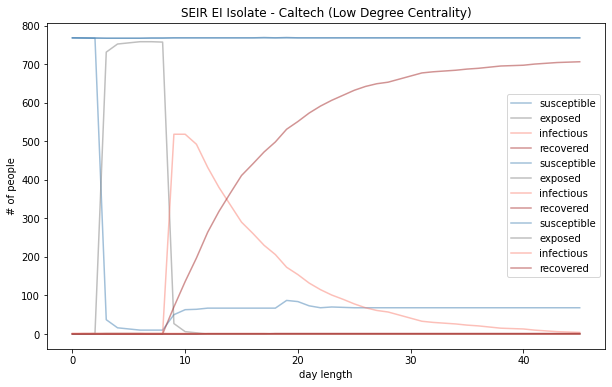

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_degC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (Low Degree Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Harmonic Centrality

##### High

At timestep 9 have highest infected num: 524
At timestep 7 have highest infected num: 499
At timestep 8 have highest infected num: 512
At timestep 7 have highest infected num: 532


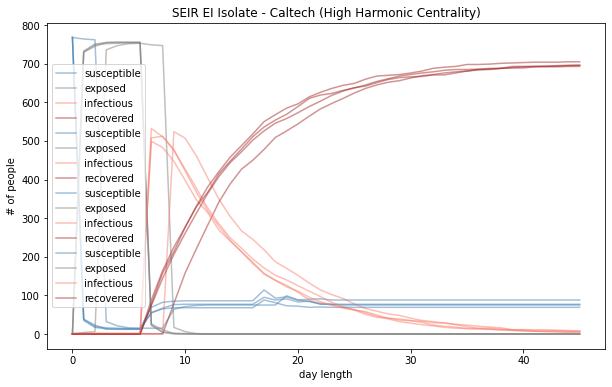

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_harC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (High Harmonic Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1


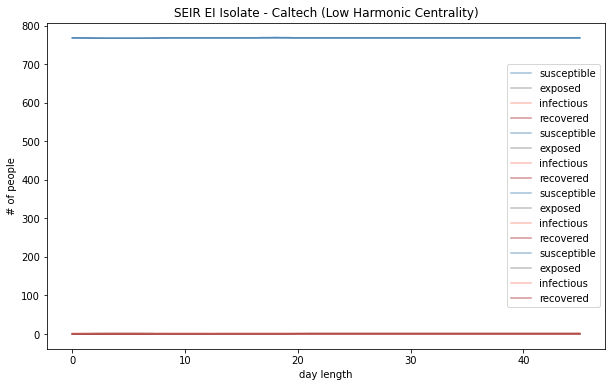

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_harC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (Low Harmonic Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Eigenvector Centrality

##### High

At timestep 7 have highest infected num: 517
At timestep 7 have highest infected num: 520
At timestep 8 have highest infected num: 523


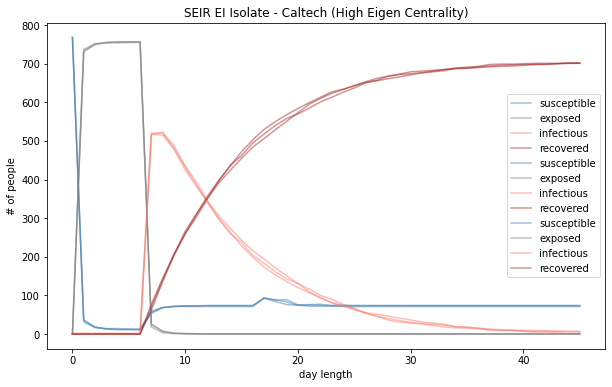

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_eigC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (High Eigen Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1
At timestep 0 have highest infected num: 1


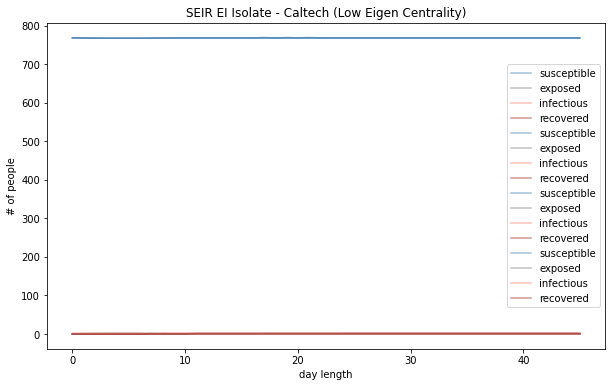

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_eigC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (Low Eigen Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

#### Betweeness Centrality

##### High-Low Compare

At timestep 7 have highest infected num: 518
At timestep 9 have highest infected num: 510


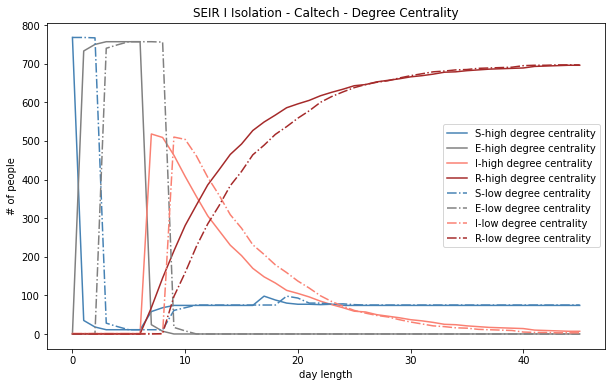

In [ ]:
bet = [709, 744]
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in bet:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    if bet.index(startNode) == 0:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-high degree centrality")
        plt.plot(np.arange(days+1), e, color="grey", label="E-high degree centrality")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-high degree centrality")
        plt.plot(np.arange(days+1), r, color="brown", label="R-high degree centrality")
    else:
        plt.plot(np.arange(days+1), s, color="steelblue", label="S-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), e, color="grey", label="E-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), i, color="salmon", label="I-low degree centrality", linestyle="-.")
        plt.plot(np.arange(days+1), r, color="brown",  label="R-low degree centrality", linestyle="-.")

ax.set_title("SEIR I Isolation - Caltech - Degree Centrality")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### High

At timestep 7 have highest infected num: 493
At timestep 8 have highest infected num: 513
At timestep 7 have highest infected num: 524
At timestep 7 have highest infected num: 529


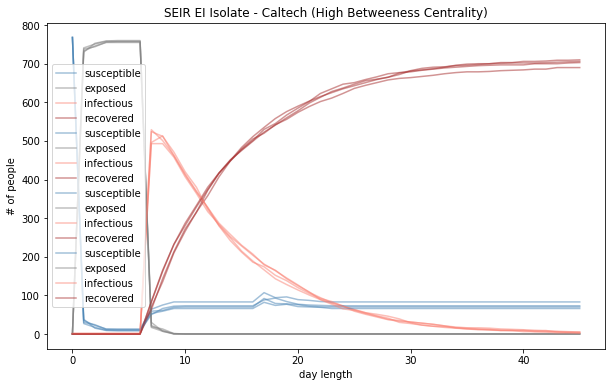

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in high_betC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (High Betweeness Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

##### Low

At timestep 0 have highest infected num: 1
At timestep 15 have highest infected num: 533
At timestep 0 have highest infected num: 1


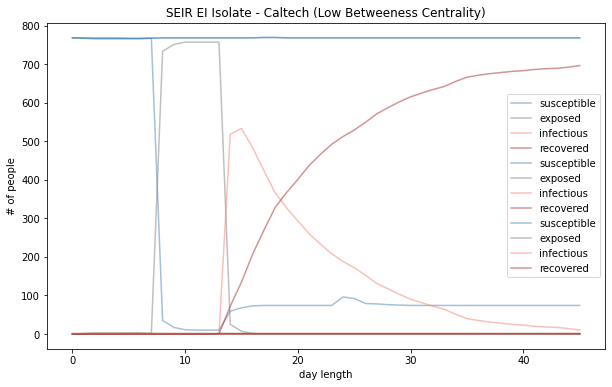

In [ ]:
fig, ax = plt.subplots(figsize=(10,6)) 
for startNode in low_betC:
    G_caltech_c = nx.read_edgelist(path, nodetype=int)
    caltech_edges = {}
    for node in G_caltech_c.nodes():
        caltech_edges[node] = list(G_caltech_c.edges(node))

    SEIR_caltech_EI = SEIR_simulator_EI_isolation_centrality(G_caltech_c, n_caltech+1, days, caltech_edges, startNode)
    s_list, e_list, i_list, r_list = SEIR_caltech_EI.SEIR_simulator()

    s = [len(s_list[i]) for i in range(days+1)]
    e = [len(e_list[i]) for i in range(days+1)]
    i = [len(i_list[i]) for i in range(days+1)]
    r = [len(r_list[i]) for i in range(days+1)]
    print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))

    
    plt.plot(np.arange(days+1), s, color = "steelblue", alpha = 0.5, label="susceptible")
    plt.plot(np.arange(days+1), e, color = "grey", alpha = 0.5, label="exposed")
    plt.plot(np.arange(days+1), i, color = "salmon", alpha = 0.5, label="infectious")
    plt.plot(np.arange(days+1), r, color = "brown", alpha = 0.5, label="recovered")

ax.set_title("SEIR EI Isolate - Caltech (Low Betweeness Centrality)")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

# 1000 rand graph simulation (random start)

## no isolation

In [ ]:
n = 10**3
G_sim1 = nx.Graph()
G_sim1.add_nodes_from(np.arange(n))
for i in range(n):
    size = np.random.choice(np.arange(1,9))
    edges = np.random.choice(np.arange(n), size)
    for e in edges:
        G_sim1.add_edge(i, e)

At timestep 19 have highest infected num: 500


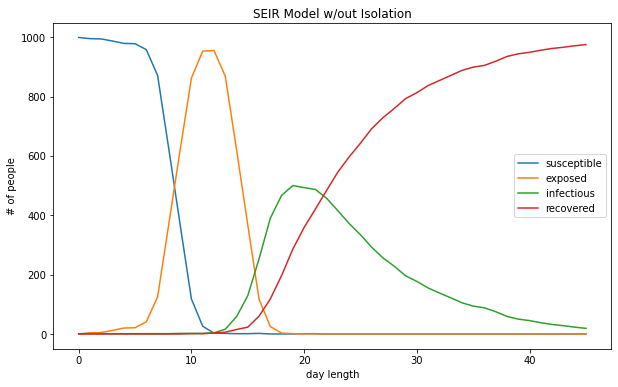

In [ ]:
SEIR_noIsolation = SEIR_simulator_no_isolation(G_sim1, n, days)
s_list, e_list, i_list, r_list = SEIR_noIsolation.SEIR_simulator()
s = [len(s_list[i]) for i in range(days+1)]
e = [len(e_list[i]) for i in range(days+1)]
i = [len(i_list[i]) for i in range(days+1)]
r = [len(r_list[i]) for i in range(days+1)]
print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s, label="susceptible")
plt.plot(np.arange(days+1), e, label="exposed")
plt.plot(np.arange(days+1), i, label="infectious")
plt.plot(np.arange(days+1), r, label="recovered")

ax.set_title("SEIR Model w/out Isolation")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

## Isolate at I

In [ ]:
n = 10**3
G_sim1_I = nx.Graph()
G_sim1_I.add_nodes_from(np.arange(n))
for i in range(n):
    size = np.random.choice(np.arange(1,9))
    edges = np.random.choice(np.arange(n), size)
    for e in edges:
        G_sim1_I.add_edge(i, e)

At timestep 16 have highest infected num: 555


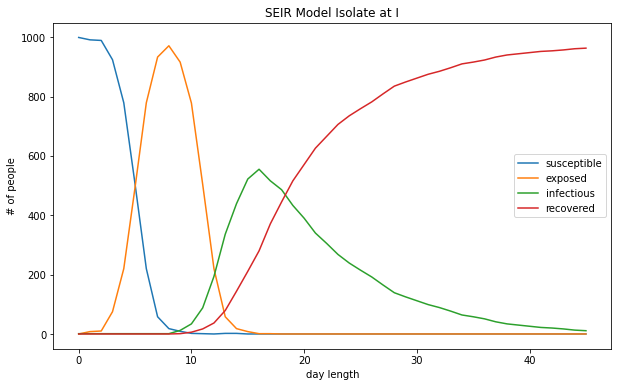

In [ ]:
edgeDict = {}
for node in range(n):
    edgeDict[node] = list(G_sim1_I.edges(node))
    
     
SEIR_I_Isolation = SEIR_simulator_I_isolation(G_sim1_I, n, days,edgeDict)
s_list, e_list, i_list, r_list = SEIR_I_Isolation.SEIR_simulator()
s = [len(s_list[i]) for i in range(days+1)]
e = [len(e_list[i]) for i in range(days+1)]
i = [len(i_list[i]) for i in range(days+1)]
r = [len(r_list[i]) for i in range(days+1)]
print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s, label="susceptible")
plt.plot(np.arange(days+1), e, label="exposed")
plt.plot(np.arange(days+1), i, label="infectious")
plt.plot(np.arange(days+1), r, label="recovered")

ax.set_title("SEIR Model Isolate at I")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

## Isolate at E

### 6 isolation days

At timestep 15 have highest infected num: 387


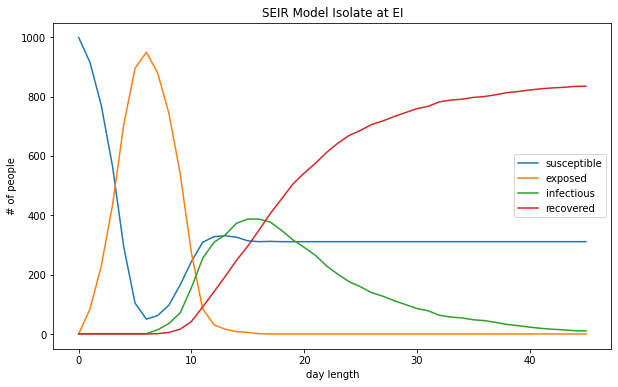

In [ ]:
G_sim1_EI = nx.Graph()
G_sim1_EI.add_nodes_from(np.arange(n))
for i in range(n):
    size = np.random.choice(np.arange(1,9))
    edges = np.random.choice(np.arange(n), size)
    for e in edges:
        G_sim1_EI.add_edge(i, e)

edgeDict = {}
for node in range(n):
    edgeDict[node] = list(G_sim1_EI.edges(node))
    
     
SEIR_EI_Isolation = SEIR_simulator_EI_isolation(G_sim1_EI, n, days, edgeDict, 6, 0.6, 2)
s_list, e_list, i_list, r_list = SEIR_EI_Isolation.SEIR_simulator()
s = [len(s_list[i]) for i in range(days+1)]
e = [len(e_list[i]) for i in range(days+1)]
i = [len(i_list[i]) for i in range(days+1)]
r = [len(r_list[i]) for i in range(days+1)]
print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s, label="susceptible")
plt.plot(np.arange(days+1), e, label="exposed")
plt.plot(np.arange(days+1), i, label="infectious")
plt.plot(np.arange(days+1), r, label="recovered")

ax.set_title("SEIR Model Isolate at EI")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

### 14 Isolation days

At timestep 21 have highest infected num: 353


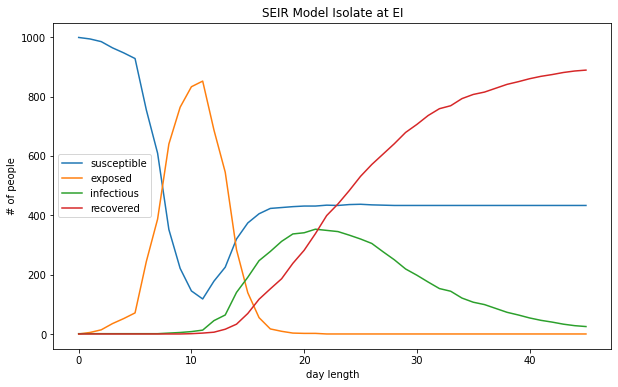

In [ ]:
G_sim1_EI = nx.Graph()
G_sim1_EI.add_nodes_from(np.arange(n))
for i in range(n):
    size = np.random.choice(np.arange(1,9))
    edges = np.random.choice(np.arange(n), size)
    for e in edges:
        G_sim1_EI.add_edge(i, e)

edgeDict = {}
for node in range(n):
    edgeDict[node] = list(G_sim1_EI.edges(node))
    
     
SEIR_EI_Isolation = SEIR_simulator_EI_isolation(G_sim1_EI, n, days, edgeDict, 14, 0.6, 2)
s_list, e_list, i_list, r_list = SEIR_EI_Isolation.SEIR_simulator()
s = [len(s_list[i]) for i in range(days+1)]
e = [len(e_list[i]) for i in range(days+1)]
i = [len(i_list[i]) for i in range(days+1)]
r = [len(r_list[i]) for i in range(days+1)]
print("At timestep",i.index(max(i)), "have highest infected num:" , max(i))
fig, ax = plt.subplots(figsize=(10,6)) 
plt.plot(np.arange(days+1), s, label="susceptible")
plt.plot(np.arange(days+1), e, label="exposed")
plt.plot(np.arange(days+1), i, label="infectious")
plt.plot(np.arange(days+1), r, label="recovered")

ax.set_title("SEIR Model Isolate at EI")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()

# Isolate EI Modified with different $p_{se}$ in Isolation (random start)

In [ ]:
class SEIR_simulator_EI_isolation_modified:
    def __init__(self, G, n, days, edgeList, p_se_isolation, delay=2):
        self.n = n
        self.days = days
        self.p_se_isolation = p_se_isolation
        self.p_se = 0.6   # prob S-E
        self.p_ei = 0.125 # prob E-I
        self.p_ir = 0.143 # prob I-R
        self.G = G
        self.G_grid = nx.Graph()
        self.edgeList = edgeList
        self.delay = delay
        self.nodes = [0]*n
        self.SList = {}   
        self.EList = {}
        self.IList = {}
        self.RList = {}
        self.EIList = {}
        self.isolate = {}
        for timestep in range(self.days+7):
            self.SList[timestep] = []
            self.EList[timestep] = []
            self.IList[timestep] = []
            self.RList[timestep] = []
            self.EIList[timestep] = []
            self.isolate[timestep] = []
        self.spreadList = []
        self.gotList = []
        self.startNode = np.random.randint(0, n)
        

    def SEIR_simulator(self):
        
        self.nodes[self.startNode] = 1
        self.SList[0] = list(self.G.nodes())
        self.SList[0].remove(self.startNode)
        self.IList[0].append(self.startNode)
        self.spreadList.append(self.startNode)
        self.gotList.append(self.startNode)
        self.G_grid.add_node(self.startNode)
        
        # simulate for 40 days
        for day in range(1,self.days+1):
            self.SEI_stage(day)    # S -> E (0.6), E -> I (0.125)
            if day > 6: 
                self.IR_stage(day) # I -> R (0.143)
        
        return list(self.SList.values()), list(self.EList.values()), list(self.IList.values()), list(self.RList.values())
        
    
    def SEI_stage(self, day):
        # Update dictionarys from day before
        self.SList[day] = list(set(self.SList[day] + self.SList[day-1]))
        self.EList[day] = list(set(self.EList[day] + self.EList[day-1]))
        self.IList[day] = list(set(self.IList[day] + self.IList[day-1]))
        self.EIList[day] = list(set(self.EIList[day] + self.EIList[day-1]))
        self.isolate[day] = list(set(self.isolate[day] + self.isolate[day-1]))

        if day >= 6:
            for node in self.EList[day-6]:
                # nodes in E but not I return to S after 6 days
                if node in self.EList[day] and node not in self.gotList:
                    self.EList[day].remove(node)
                    self.SList[day].append(node)
                # nodes get I during E 6 days remove from E
                elif node in self.EList[day] and node in self.gotList:
                    self.EList[day].remove(node)

        # check nodes positive in E or I
        for node in self.spreadList:
            # Pass to neighbors
            for adj in list(self.G.adj[node]):
                # 0.6 prob got Exposed
                if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se:
                    # Exposed list
                    if adj not in self.EIList[day]:
                        self.EIList[day].append(adj)
                        self.EList[day].append(adj)
                    # Remove from SList
                    if adj in self.SList[day]:
                        self.SList[day].remove(adj)
                    # 0.125 prob E to I
                    if np.random.uniform(0,1) <= self.p_ei:
                        self.spreadList.append(adj)   # Ability to spread
                        self.nodes[adj] = 1           # Will not get infected again 
                        self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                        self.gotList.append(adj)      # Track all the nodes has been infected in the history
                        self.EIList[day].remove(adj)  # Nodes won't be exposed again
                    
                    # Following 6 days, this nodes will not be in S
                    for d in range(day, day+6):
                        if adj in self.SList[d]:
                            self.SList[d].remove(adj)
                            
        # 2 days delay, then start isolate 50% esposed from day before
        if day > self.delay:
            self.isolate_EI(day) #Isolate
    
    def isolate_EI(self, day):
        
#         print('Day',day,'In Isolation:')
#         print("Isolation list:", self.isolate[day])
#         print("nodes in list:", self.G_grid.nodes())
        
        # remove the ones after isolation
        if day > 14:
            for node in self.isolate[day-14]:
                # not infected after isolation, put back in G
                if node in self.G_grid.nodes() and node not in self.gotList:
                    self.G_grid.remove_node(node)
                    if node in self.isolate[day]:
                        self.isolate[day].remove(node)
                    self.SList[day].append(node)
                    self.G.add_node(node)
                    # put back into original network
                    for adj in self.edgeList[node]:
                        if adj in self.G.nodes():
                            self.G.add_edge(adj, node)
            self.isolate_I(day) # Isolate all infected
        
        # add in new isolated nodes, 50% chance
        for i_node in list(set(self.EList[day-self.delay])):
            if np.random.uniform(0,1) <= 0.75:
                if i_node in self.spreadList:
                    self.spreadList.remove(i_node)
                self.isolate[day].append(i_node)
                if i_node in self.G.nodes():
                    self.G.remove_node(i_node)
                self.isolate[day].append(i_node)
                n_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
                self.G_grid.add_node(i_node)
                for n in n_nodes:
                    if len(list(self.G_grid.edges(n))) < 4:
                        self.G_grid.add_edge(i_node, n)

        # Grid isolation
        for node in self.G_grid.nodes():
            if node in self.gotList:
                for adj in self.G_grid.adj[node]:
                    # during Isolation got Exposed
                    if self.nodes[adj] == 0 and np.random.uniform(0,1) <= self.p_se_isolation: 
                        # 0.125 prob E to I
                        if np.random.uniform(0,1) <= self.p_ei:
                            self.nodes[adj] = 1           # Will not get infected again 
                            self.IList[day+6].append(adj) # Add in Infected dict 6 days after
                            self.gotList.append(adj)      # Track all the nodes has been infected in the history
                            self.EIList[day].remove(adj)  # Nodes won't be exposed again
                            
    def isolate_I(self, day):
        # all infected nodes will be added in isolation
        self.G.remove_nodes_from(self.IList[day])
        for node in self.IList[day]:
            self.G_grid.add_node(node)
            if node in self.spreadList:
                self.spreadList.remove(node) # move to isolation, no more spread
            i_nodes = np.random.choice(list(self.G_grid.nodes()), 4)
            for i_node in i_nodes:
                if len(self.G_grid.edges(i_node)) < 4:
                    self.G_grid.add_edge(node, i_node)
            
        
    def IR_stage(self, day):
        # Update recover dict from day before
        self.RList[day] = list(set(self.RList[day] + self.RList[day-1]))
        
        # there is 0.143 prob everyday I to R
        for node in self.IList[day]:
            if np.random.uniform(0,1) <= self.p_ir:
                self.RList[day].append(node) # Add to Recover dict
                self.IList[day].remove(node) # Remove from Infected dict
                if node in self.G_grid.nodes():
                    self.G_grid.remove_node(node)# remove from grid isolation
        
        

### Isolation SE prob 0.1-1

In [ ]:
p_se_isolation = np.arange(0.05, 1+1/46, (1+1/46-0.05)/46)
len(p_se_isolation)

46

In [ ]:
n = 10**3
days = 45
Ss = []
Es = []
Is = []
Rs = []

for p_se in p_se_isolation:
    s_sum = np.array([0]*46)
    e_sum = np.array([0]*46)
    i_sum = np.array([0]*46)
    r_sum = np.array([0]*46)
    for i in range(50):
        G_sim1_EI = nx.Graph()
        G_sim1_EI.add_nodes_from(np.arange(n))
        for i in range(n):
            size = np.random.choice(np.arange(1,9))
            edges = np.random.choice(np.arange(n), size)
            for e in edges:
                G_sim1_EI.add_edge(i, e)

        edgeDict = {}
        for node in range(n):
            edgeDict[node] = list(G_sim1_EI.edges(node))


        SEIR_EI_Isolation = SEIR_simulator_EI_isolation_modified(G_sim1_EI, n, days, edgeDict, p_se)
        s_list, e_list, i_list, r_list = SEIR_EI_Isolation.SEIR_simulator()
        
        s_list = np.array([len(s_list[i]) for i in range(days+1)])
        e_list = np.array([len(e_list[i]) for i in range(days+1)])
        i_list = np.array([len(i_list[i]) for i in range(days+1)])
        r_list = np.array([len(r_list[i]) for i in range(days+1)])
        
        s_sum = s_sum + s_list
        e_sum = e_sum + e_list
        i_sum = i_sum + i_list
        r_sum = r_sum + r_list
        
    Ss.append(s_sum/50)
    Es.append(e_sum/50)
    Is.append(i_sum/50)
    Rs.append(r_sum/50)


In [ ]:
zs = [[0]*(days+1) for i in range(len(p_se_isolation))]
ys = [[0]*(days+1) for i in range(len(p_se_isolation))]
xs = [[0]*len(p_se_isolation) for i in range(days+1)]
print(days, np.shape(xs), np.shape(ys), np.shape(zs))

45 (46, 46) (46, 46) (46, 46)


In [ ]:
for i in range(len(p_se_isolation)):
    for j in range(days+1):
        xs[i][j] = p_se_isolation[i]
        ys[i][j] = j
        zs[i][j] = Ss[i][j]

### S 3d plot

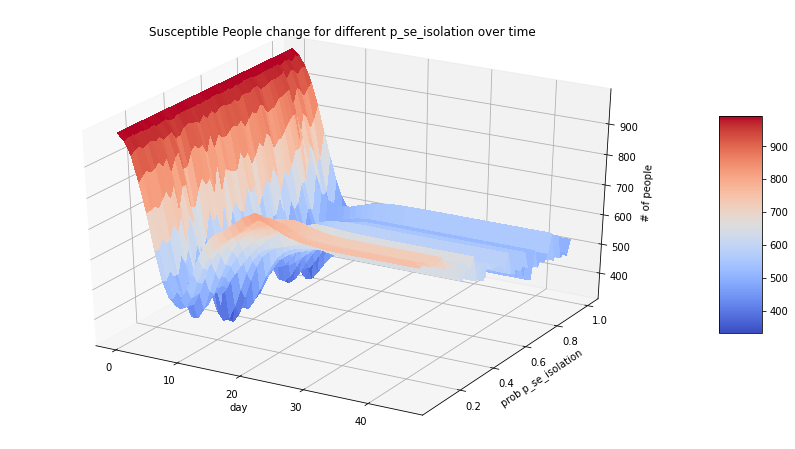

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d') 
# ax.scatter3D(ys, xs, zs, cmap="Blues")
plot = ax.plot_surface(np.array(ys), np.array(xs), np.array(zs), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel("prob p_se_isolation") 
ax.set_xlabel("day") 
ax.set_zlabel("# of people");
ax.set_title("Susceptible People change for different p_se_isolation over time")

fig.colorbar(plot, shrink=0.5, aspect=5)
plt.show()


### E 3d plot

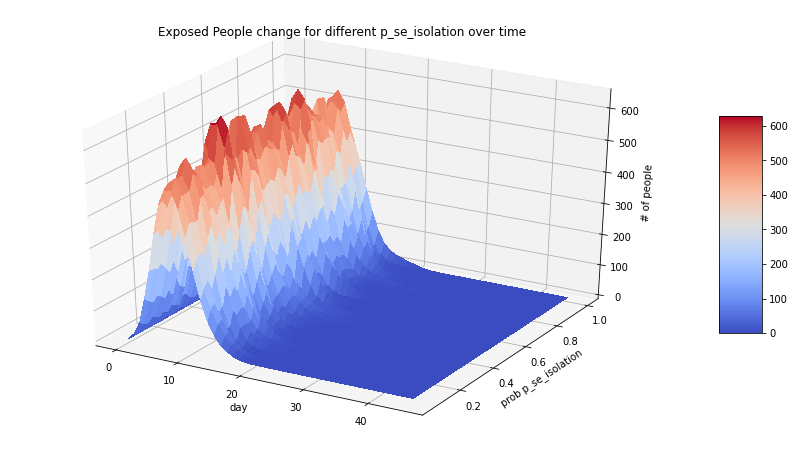

In [ ]:
for i in range(len(p_se_isolation)):
    for j in range(days+1):
        xs[i][j] = p_se_isolation[i]
        ys[i][j] = j
        zs[i][j] = Es[i][j]

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d') 
# ax.scatter3D(ys, xs, zs, cmap="Blues")
plot = ax.plot_surface(np.array(ys), np.array(xs), np.array(zs), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel("prob p_se_isolation") 
ax.set_xlabel("day") 
ax.set_zlabel("# of people");
ax.set_title("Exposed People change for different p_se_isolation over time")

fig.colorbar(plot, shrink=0.5, aspect=5)
plt.show()


### I 3d plot

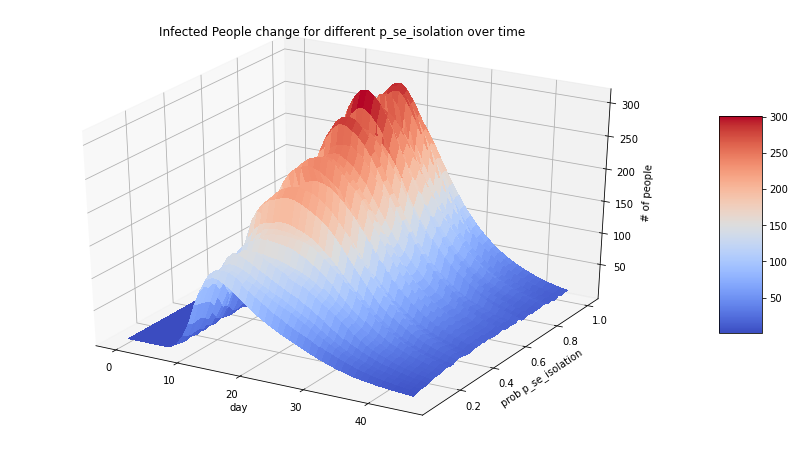

In [ ]:
for i in range(len(p_se_isolation)):
    for j in range(days+1):
        xs[i][j] = p_se_isolation[i]
        ys[i][j] = j
        zs[i][j] = Is[i][j]

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d') 
# ax.scatter3D(ys, xs, zs, cmap="Blues")
plot = ax.plot_surface(np.array(ys), np.array(xs), np.array(zs), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel("prob p_se_isolation") 
ax.set_xlabel("day") 
ax.set_zlabel("# of people");
ax.set_title("Infected People change for different p_se_isolation over time")

fig.colorbar(plot, shrink=0.5, aspect=5)
plt.show()


### R 3d plot

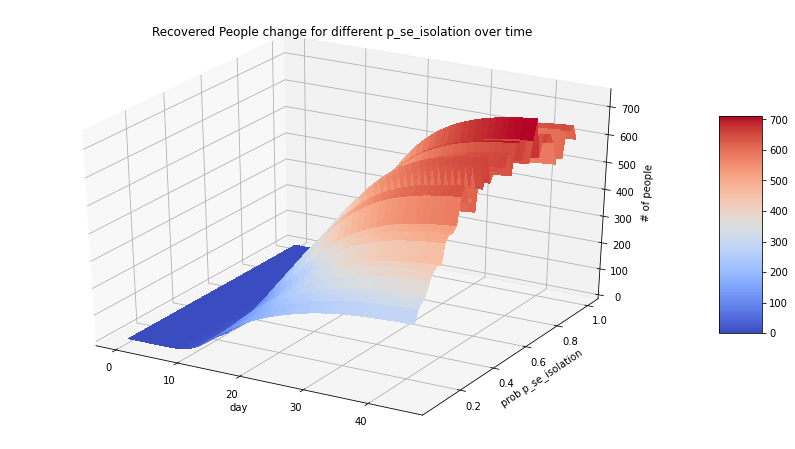

In [ ]:
for i in range(len(p_se_isolation)):
    for j in range(days+1):
        xs[i][j] = p_se_isolation[i]
        ys[i][j] = j
        zs[i][j] = Rs[i][j]

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d') 
# ax.scatter3D(ys, xs, zs, cmap="Blues")
plot = ax.plot_surface(np.array(ys), np.array(xs), np.array(zs), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel("prob p_se_isolation") 
ax.set_xlabel("day") 
ax.set_zlabel("# of people");
ax.set_title("Recovered People change for different p_se_isolation over time")

fig.colorbar(plot, shrink=0.5, aspect=5)
plt.show()


# Delay Analysis

2
5


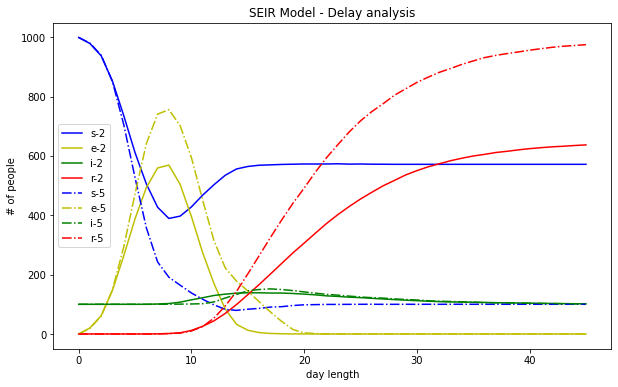

In [ ]:
n = 10**3
days = 45
delays = [2, 5]
Ss = []
Es = []
Is = []
Rs = []

fig, ax = plt.subplots(figsize=(10,6)) 
for d in delays:
    e = np.array([0]*46)
    i = np.array([0]*46)
    s = np.array([0]*46)
    r = np.array([0]*46)
    print(d)
    for i in range(10):
        G_sim1_EI = nx.Graph()
        G_sim1_EI.add_nodes_from(np.arange(n))
        for i in range(n):
            size = np.random.choice(np.arange(1,9))
            edges = np.random.choice(np.arange(n), size)
            for ed in edges:
                G_sim1_EI.add_edge(i, ed)

        edgeDict = {}
        for node in range(n):
            edgeDict[node] = list(G_sim1_EI.edges(node))


        SEIR_EI_Isolation = SEIR_simulator_EI_isolation(G_sim1_EI, n, days, edgeDict,14, 0.6, d)
        s_list, e_list, i_list, r_list = SEIR_EI_Isolation.SEIR_simulator()
        s += np.array([len(s_list[i]) for i in range(days+1)])
        e += np.array([len(e_list[i]) for i in range(days+1)])
        i += np.array([len(i_list[i]) for i in range(days+1)])
        r += np.array([len(r_list[i]) for i in range(days+1)])
    if d == 2:
        plt.plot(np.arange(days+1), s/10, label="s-"+str(d), color="b")
        plt.plot(np.arange(days+1), e/10, label="e-"+str(d), color='y')
        plt.plot(np.arange(days+1), i/10, label="i-"+str(d), color='g')
        plt.plot(np.arange(days+1), r/10, label="r-"+str(d), color='r')
    else:
        plt.plot(np.arange(days+1), s/10, label="s-"+str(d), linestyle='-.', color="b")
        plt.plot(np.arange(days+1), e/10, label="e-"+str(d), linestyle='-.', color="y")
        plt.plot(np.arange(days+1), i/10, label="i-"+str(d), linestyle='-.', color="g")
        plt.plot(np.arange(days+1), r/10, label="r-"+str(d), linestyle='-.', color="r")
        
ax.set_title("SEIR Model - Delay analysis")
plt.xlabel("day length") 
plt.ylabel("# of people")
ax.legend()
plt.show()